In [567]:
#Importazioni delle librerie Python

import pandas as pd
import numpy as np
import random as rd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from branca.element import Figure
import folium
from folium.features import *
import folium.plugins
import matplotlib.pyplot as plt
%matplotlib inline

In [568]:
#Aggancio dei file CSV di analisi dal Comune di Milano

INQUINAMENTO_MILANO='https://dati.comune.milano.it/dataset/e340a8c6-b68b-49e8-9569-910f31865489/resource/7636e84c-8dd6-430d-9ce8-8aa243e18fd3/download/qaria_datoariagiornostazione_2022-01-05.csv'
df_Rilevazioni=pd.read_csv(INQUINAMENTO_MILANO, sep=';')

df_Rilevazioni.replace(r'^\s*$', np.nan, regex=True)
df_Rilevazioni.dropna(inplace=True)

STAZIONI_MONITORAGGIO='https://dati.comune.milano.it/dataset/d6960c75-0a02-4fda-a85f-3b1c4aa725d6/resource/b301f327-7504-4efc-8b4a-5f4a29f9d0ff/download/qaria_stazione.csv'
df_StazioniMonitoraggio=pd.read_csv(STAZIONI_MONITORAGGIO, sep=';')

QUARTIERI_MILANO='https://dati.comune.milano.it/dataset/e8e765fc-d882-40b8-95d8-16ff3d39eb7c/resource/3fce7202-0076-4a7b-ac2c-d2ab9b5dc658/download/ds964_nil_wm_4326.csv'

In [569]:
#Analisi delle informazioni principali del data frame

df_Rilevazioni.info()
df_Rilevazioni.describe()
df_Rilevazioni.columns
df_Rilevazioni.shape

df_StazioniMonitoraggio.info()
df_StazioniMonitoraggio.describe
df_StazioniMonitoraggio.columns
df_StazioniMonitoraggio.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4416 entries, 1 to 6279
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stazione_id  4416 non-null   int64  
 1   data         4416 non-null   object 
 2   inquinante   4416 non-null   object 
 3   valore       4416 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 172.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_amat             9 non-null      int64  
 1   nome                9 non-null      object 
 2   id_arpa             9 non-null      int64  
 3   inizio_operativita  9 non-null      object 
 4   fine_operativita    9 non-null      object 
 5   inquinanti          9 non-null      object 
 6   LONG_X_4326         9 non-null      float64
 7   LAT_Y_4326          9 non-null  

(9, 9)

In [570]:
#Ridenominazioni di alcune stringhe in specifiche colonne per comodità di analisi

df_StazioniMonitoraggio['nome']=df_StazioniMonitoraggio['nome'].str.replace('p.le','piazzale',regex=True)
df_StazioniMonitoraggio['nome']=df_StazioniMonitoraggio['nome'].str.replace('*','',regex=True)

#Ridenominazione di alcune colonne per comodità di analisi

df_StazioniMonitoraggio.rename(columns={'id_amat':'stazione_id'},inplace=True)
df_StazioniMonitoraggio.rename(columns={'nome':'via/piazza'},inplace=True)
df_StazioniMonitoraggio.rename(columns={'LONG_X_4326':'Longitudine'},inplace=True)
df_StazioniMonitoraggio.rename(columns={'LAT_Y_4326':'Latitudine'},inplace=True)

#Visualizzazione della tabella

df_StazioniMonitoraggio

,stazione_id,via/piazza,id_arpa,inizio_operativita,fine_operativita,inquinanti,Longitudine,Latitudine,Location
0,1,piazzale Abbiategrasso,126,1900-01-01,2017-08-31,NO2,9.18219,45.432301,"(45.432300567627, 9.18218994140625)"
1,2,via Pascal,100,1900-01-01,2099-12-31,"C6H6, PM10, NO2, SO2, SO2, PM25, O3",9.23478,45.474098,"(45.4740982055664, 9.23478031158447)"
2,3,viale Liguria,107,1900-01-01,2099-12-31,"CO_8h, NO2",9.16944,45.444199,"(45.4441986083984, 9.16944026947021)"
3,4,viale Marche,2,1900-01-01,2099-12-31,"NO2, PM10, CO_8h, C6H6",9.19084,45.496300,"(45.4962997436523, 9.19083976745605)"
4,5,Parco Lambro,124,1900-01-01,2017-08-31,"O3, NO2",9.24730,45.499599,"(45.4995994567871, 9.24730014801025)"
5,6,via Senato,125,1900-01-01,2099-12-31,"PM25, C6H6, CO_8h, PM10, NO2",9.19792,45.470501,"(45.4705009460449, 9.19791984558105)"
6,7,Verziere,85,1900-01-01,2099-12-31,"PM10, O3, NO2, CO_8h",9.19534,45.463501,"(45.4635009765625, 9.19534015655518)"
7,8,piazzale Zavattari,7,1900-01-01,2017-08-31,"CO_8h, C6H6, NO2",9.14177,45.476101,"(45.4761009216309, 9.141770362854)"
8,9,via Juvara,7,1900-01-01,2007-06-11,"PM10, NO2, PM25, SO2, O3",9.22045,45.473499,"(45.4734992980957, 9.22045040130615)"


In [571]:
#Casting di alcune colonne per correttezza di analisi

df_Rilevazioni['data']=pd.to_datetime(df_Rilevazioni['data'])
df_Rilevazioni['inquinante'] = df_Rilevazioni['inquinante'].astype('string')

In [572]:
#Sort del df sulla colonna valore in ordine decrescente

df_Rilevazioni.sort_values(by='valore',ascending=False)

,stazione_id,data,inquinante,valore
2335,7,2021-08-12,O3,192.00
3342,7,2021-06-18,O3,183.00
2317,2,2021-08-12,O3,182.00
3324,2,2021-06-18,O3,177.00
3123,2,2021-06-29,O3,169.00
...,...,...,...,...
2356,6,2021-08-11,CO_8h,0.25
3000,4,2021-07-06,CO_8h,0.25
3415,6,2021-06-15,CO_8h,0.25
2694,6,2021-07-23,CO_8h,0.25


In [573]:
#Distinct della colonna stazione_id per capire quante stazioni di monitoraggio ci sono a Milano

df_Rilevazioni['stazione_id'].unique()

array([2, 3, 4, 6, 7])

In [574]:
#GroupBy dei valori di massimo inquinanemto per ogni stringa in distinct della colonna inquinante

GroupedMaxInquinanti=df_Rilevazioni.groupby(by='stazione_id').max()
GroupedMaxInquinanti

GroupedMaxInquinanti.insert(0,'index','NaN')
GroupedMaxInquinanti

,index,data,inquinante,valore
stazione_id,,,,
2,NaN,2021-12-31,SO2,182.0
3,NaN,2021-12-31,NO2,155.0
4,NaN,2021-12-31,PM10,147.0
6,NaN,2021-12-31,PM25,152.0
7,NaN,2021-12-31,PM10,192.0


In [575]:
#GroupedMaxInquinanti.set_index('index')


In [576]:
GroupedMaxInquinanti.loc[GroupedMaxInquinanti['inquinante'] == 'PM10']

,index,data,inquinante,valore
stazione_id,,,,
4,NaN,2021-12-31,PM10,147.0
7,NaN,2021-12-31,PM10,192.0


<b>-------------------------------------ANALISI DEGLI INQUINANTI-------------------------------------</b>

In [577]:
#Calcolo del massimo valore inquinante

MAX_Inquinante=df_Rilevazioni['valore'].max()
MAX_Inquinante

#Calcolo della data in cui c'è stato il massimo valore inquinante

Data_Max_Inquinante=df_Rilevazioni['data'][df_Rilevazioni['valore']==MAX_Inquinante]
Data_Max_Inquinante

2335   2021-08-12
Name: data, dtype: datetime64[ns]

<b>-------------------------------------ANALISI DEL PM10-------------------------------------</b>

In [578]:
#Quali indici di riga hannno inquinante PM10?
#Restituisce un array di valori booleani che rispettano la condizione indicata (inquinante = PM10) di lunghezza pari alla lunghezza del df

PM10_condition=df_Rilevazioni['inquinante']=='PM10'
PM10_condition.head()

#Calcolo il massimo valore di inquinamento dell'inquinante PM10

MAX_PM10=df_Rilevazioni[PM10_condition]['valore'].max()
MAX_PM10

#Calcolo una colonna di appoggio con il massimo valore di inquinante di PM10

df_Rilevazioni['ColonnaAppoggioMAX_PM10']=MAX_PM10
df_Rilevazioni.head()

df_Rilevazioni[df_Rilevazioni['valore']==df_Rilevazioni['ColonnaAppoggioMAX_PM10']]


#Data_MAXPM10=df [df['data']!=''] [df['valore']==MAX_PM10]

Data_MAXPM10=df_Rilevazioni['data'][df_Rilevazioni['valore']==MAX_PM10]
Data_MAXPM10

330   2021-12-14
Name: data, dtype: datetime64[ns]

<b>-------------------------------------INSERIMENTO GRAFICI-------------------------------------</b>

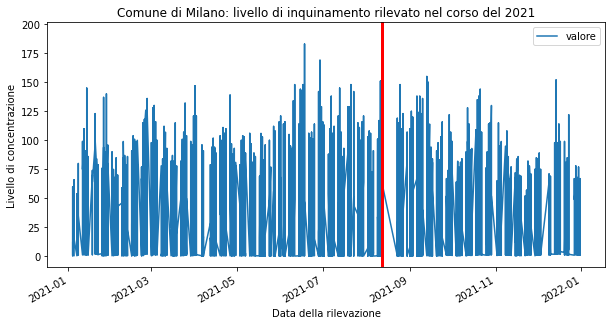

In [579]:
#Plot del grafico Data-Inquinamento

Grafico_DataInquinamento=df_Rilevazioni.plot(x='data',y='valore',title='Comune di Milano: livello di inquinamento rilevato nel corso del 2021',figsize=(10,5))

#Ridenominazione degli assi del grafico

Grafico_DataInquinamento.set(xlabel="Data della rilevazione", ylabel="Livello di concentrazione")

#Inserimento di una barra che evidenzia il giorno di massimo inquinamento

Grafico_DataInquinamento.axvline(x=Data_Max_Inquinante,ymin=0,ymax=MAX_Inquinante,color='r',linewidth=3)

<b>-------------MAPPATURA GRAFICA DELLE STAZIONI DI MONITORAGGIO E VISUALIZZAZIONE DEI RISPETTIVI VALORI DI MASSIMO INQUINANTE-------------</b>

In [580]:
#Calcolo della colonna geometry necessaria a trasformare le coordinate di Long e Lat in coordinate cartesiamo xy sotto forma di POINT

Mappa_Stazioni=gpd.GeoDataFrame(df_StazioniMonitoraggio,geometry=gpd.points_from_xy(df_StazioniMonitoraggio['Latitudine'], df_StazioniMonitoraggio['Longitudine']))
Mappa_Stazioni


,stazione_id,via/piazza,id_arpa,inizio_operativita,fine_operativita,inquinanti,Longitudine,Latitudine,Location,geometry
0,1,piazzale Abbiategrasso,126,1900-01-01,2017-08-31,NO2,9.18219,45.432301,"(45.432300567627, 9.18218994140625)",POINT (45.43230 9.18219)
1,2,via Pascal,100,1900-01-01,2099-12-31,"C6H6, PM10, NO2, SO2, SO2, PM25, O3",9.23478,45.474098,"(45.4740982055664, 9.23478031158447)",POINT (45.47410 9.23478)
2,3,viale Liguria,107,1900-01-01,2099-12-31,"CO_8h, NO2",9.16944,45.444199,"(45.4441986083984, 9.16944026947021)",POINT (45.44420 9.16944)
3,4,viale Marche,2,1900-01-01,2099-12-31,"NO2, PM10, CO_8h, C6H6",9.19084,45.496300,"(45.4962997436523, 9.19083976745605)",POINT (45.49630 9.19084)
4,5,Parco Lambro,124,1900-01-01,2017-08-31,"O3, NO2",9.24730,45.499599,"(45.4995994567871, 9.24730014801025)",POINT (45.49960 9.24730)
5,6,via Senato,125,1900-01-01,2099-12-31,"PM25, C6H6, CO_8h, PM10, NO2",9.19792,45.470501,"(45.4705009460449, 9.19791984558105)",POINT (45.47050 9.19792)
6,7,Verziere,85,1900-01-01,2099-12-31,"PM10, O3, NO2, CO_8h",9.19534,45.463501,"(45.4635009765625, 9.19534015655518)",POINT (45.46350 9.19534)
7,8,piazzale Zavattari,7,1900-01-01,2017-08-31,"CO_8h, C6H6, NO2",9.14177,45.476101,"(45.4761009216309, 9.141770362854)",POINT (45.47610 9.14177)
8,9,via Juvara,7,1900-01-01,2007-06-11,"PM10, NO2, PM25, SO2, O3",9.22045,45.473499,"(45.4734992980957, 9.22045040130615)",POINT (45.47350 9.22045)


In [581]:
#JOIN dei due df Stazioni-Rilevazioni sulla colonna stazione_id

#Join_df=GroupedMaxInquinanti.join(df_StazioniMonitoraggio.set_index('stazione_id'),on='stazione_id').set_index('stazione_id').sort_values(by=('stazione_id'),ascending=True)
#Join_df

Join_df=GroupedMaxInquinanti.join(df_StazioniMonitoraggio.set_index('stazione_id'),on='stazione_id')

In [582]:
#Seleziono del join solo le colonne utili

Join_df_simple=Join_df[['inquinante','valore','via/piazza','geometry']]
Join_df_simple

,inquinante,valore,via/piazza,geometry
stazione_id,,,,
2,SO2,182.0,via Pascal,POINT (45.47410 9.23478)
3,NO2,155.0,viale Liguria,POINT (45.44420 9.16944)
4,PM10,147.0,viale Marche,POINT (45.49630 9.19084)
6,PM25,152.0,via Senato,POINT (45.47050 9.19792)
7,PM10,192.0,Verziere,POINT (45.46350 9.19534)


In [583]:
#APPUNTI
#NumberValue=Michele['Latitudine','Longitudine','via/piazza','valore']
#for index, location_info in Stations_Locations.iterrows():[location_info["Latitudine"], location_info["Longitudine"]]

In [584]:
#Creazione della mappa di Milano su cui pinnare le stazioni di monitoraggio e il loro valore di massimo inquinante

fig = Figure(width=600, height=400)
MappaMilano=folium.Map(location=[45.464664,9.188540],zoom_start=12,control_scale=True)
fig.add_child(MappaMilano)


#Localizzazione dei pin/marker delle stazioni di monitoraggio sulla mappa

Stations_Locations=Join_df[['Latitudine','Longitudine','via/piazza','valore','inquinante']]

for index, location_info in Stations_Locations.iterrows():
    folium.Marker(
        [location_info["Latitudine"], location_info["Longitudine"]],
        popup= 'Stazione di monitoraggio di: ' + location_info['via/piazza']
        ).add_to(MappaMilano)

for index, location_info in Stations_Locations.iterrows():
    folium.Marker(
        [location_info["Latitudine"], location_info["Longitudine"]],
        icon=DivIcon(html='<b><li style="font-size:13px;color: black",>&#9679' + '' + str(location_info['inquinante']) + '=' + str(location_info['valore']) + '</li></b>')
        ).add_to(MappaMilano)
 
MappaMilano

#esempio creazione bullet point nel popup
#fgc.add_child(folium.Marker(location=[lt, ln], popup= "<h4> <b>Thana :&nbsp" + di +"</h4></b>"+ "<br><b>Cases Total: &nbsp: </b>"+str(ca)+ " person "+ "<br>" + "<b>Cases 24 hours : </b>"+ str(da)+ " person "+"<br>"+"<b>Cases 7 days: </b>"+str(we)+ " person "+"<br><b>Neighbouhood affected :  </b>"+str(ne)